In [ ]:
print('SLOGAN GENERATION FOR POLITICAL PARTIES : ')

SLOGAN GENERATION FOR POLITICAL PARTIES : 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
import pickle
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/Final_dataset_Slogans (1).csv")
slogans = df['Slogan'].dropna().astype(str).tolist()
print("Total slogans:", len(slogans))

Total slogans: 6471


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(slogans)

total_words = len(tokenizer.word_index) + 1
print("Vocabulary size:", total_words)


Vocabulary size: 828


In [ ]:
input_sequences = []
for line in slogans:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

max_seq_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

X, y = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

print("X shape:", X.shape, " y shape:", y.shape)

X shape: (21429, 16)  y shape: (21429, 828)


In [ ]:
model = Sequential([
    Embedding(total_words, 128, input_length=max_seq_len-1),
    GRU(128, return_sequences=False),
    Dropout(0.2),
    Dense(total_words, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X, y, epochs=30, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 207ms/step - accuracy: 0.0959 - loss: 5.3386 - val_accuracy: 0.0149 - val_loss: 7.2626
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.2438 - loss: 3.6639 - val_accuracy: 0.0350 - val_loss: 6.5798
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.3261 - loss: 3.0401 - val_accuracy: 0.1717 - val_loss: 5.7900
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.3680 - loss: 2.7302 - val_accuracy: 0.2091 - val_loss: 5.4324
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4011 - loss: 2.5276 - val_accuracy: 0.2552 - val_loss: 5.0987
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.4152 - loss: 2.4078 - val_accuracy: 0.2944 - val_loss: 4.9203
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.4299 - loss: 2.3264 - val_accuracy: 0.3444 - val_loss: 4.7961
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.4382 - loss: 2.2513

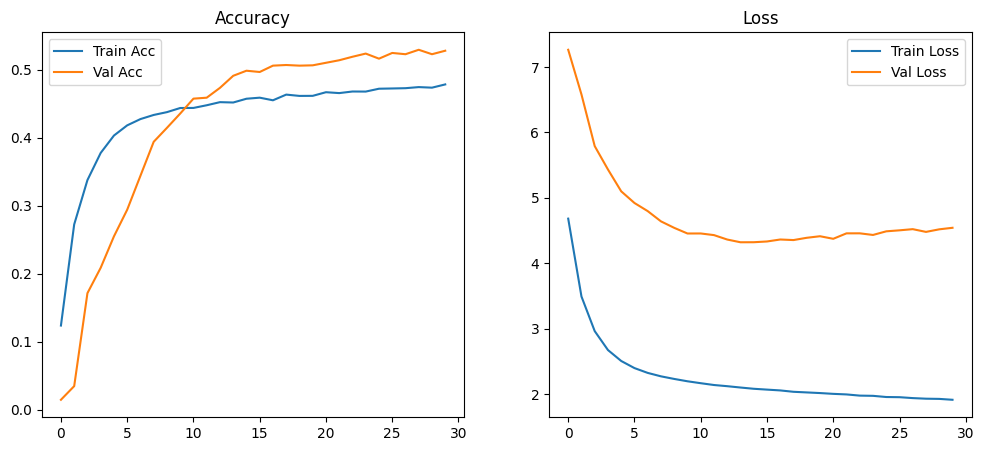

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(), plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(), plt.title("Loss")

plt.show()

In [ ]:
model.save("slogan_model.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved ")

Model and tokenizer saved 


In [ ]:
model = load_model("slogan_model.h5")
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [ ]:
def generate_slogan(seed_text, next_words=8, temperature=1.0):
    output_text = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([output_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]

        preds = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        predicted_id = np.random.choice(len(preds), p=preds)

        for word, index in tokenizer.word_index.items():
            if index == predicted_id:
                output_text += " " + word
                break
    return output_text

In [ ]:
print(generate_slogan("youth power", next_words=5, temperature=1.0))
print(generate_slogan("development for", next_words=5, temperature=0.9))

youth power poorna awaam vote for change
development for every green india rising together


In [ ]:
print(generate_slogan("youth", next_words=5, temperature=1.0))

youth shakti ka raasta desh ki


In [ ]:
print(generate_slogan("farmer", next_words=5, temperature=1.0))

farmer se nyay ki shakti india


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

save_dir = "/content/drive/MyDrive/lstm_project/"

model.save(save_dir + "lstm_model.h5")

with open(save_dir + "tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print(" Model and tokenizer saved in Google Drive ")


Mounted at /content/drive
 Model and tokenizer saved in Google Drive 


In [ ]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(10))


Shape: (6471, 2)
Columns: ['Slogan', 'Category']
                                Slogan     Category
0               Kisan Aur Constitution  Agriculture
1     Garv Ki Shakti, Vikas Ki Pragati  Development
2              Jeevan Ke Dam Par Kisan  Agriculture
3            Digital India Ka Naya Yug   Technology
4            Sustainability Ka Abhiyan  Environment
5  Janata Ki Shakti, Growth Ki Pragati  Development
6  Jeevan Ki Shakti, Samaan Ki Pragati     Equality
7                   Prosperous Vishwas        Unity
8               Inspire Bharat Ke Liye     Security
9                 Paryavaran Ka Dharti  Environment


In [ ]:
from sentence_transformers import SentenceTransformer

emb_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

corpus_texts = df["Slogan"].astype(str).tolist()

embeddings = emb_model.encode(corpus_texts, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)

print("Embeddings shape:", embeddings.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings shape: (6471, 384)


In [ ]:
!pip install sentence-transformers transformers accelerate gradio pandas numpy scikit-learn


In [ ]:
print(df.columns.tolist())


['Slogan', 'Category']


In [ ]:
print("Missing slogans:", df['Slogan'].isna().sum())
print("Unique categories:", df['Category'].unique())


Missing slogans: 0
Unique categories: ['Agriculture' 'Development' 'Technology' 'Environment' 'Equality' 'Unity'
 'Security' 'Justice' 'Empowerment' 'Culture' 'Security & Defense'
 'Education & Knowledge' 'Law & Order & Justice' 'Unknown'
 'Women Empowerment' 'Caste & Social Justice' 'International Relations'
 'Infrastructure & Urbanization' 'Secularism & Unity'
 'Economy & Inflation' 'Nationalism' 'Welfare'
 'Technology & Digital Governance' 'Minority & Tribal Rights'
 'Populism & Freebies' 'Farmers' 'Governance & Accountability'
 'Regional Identity & Federalism' 'Anti-Corruption'
 'Environment & Climate' 'Youth & Employment' 'Health & Pandemic']


In [ ]:
import os
import math
from typing import List, Dict, Optional
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
import gradio as gr
import re

CSV_PATH = "/content/Final_dataset_Slogans (1).csv"

df = pd.read_csv(CSV_PATH)
df = df.rename(columns={c: c.strip().title() for c in df.columns})
df = df.dropna(subset=["Slogan"]).copy()
df["Slogan"] = df["Slogan"].astype(str).str.strip()
df = df.drop_duplicates(subset=["Slogan"]).reset_index(drop=True)

for col in ["Theme", "Party", "Source"]:
    if col not in df.columns:
        df[col] = "Unknown"
    df[col] = df[col].fillna("Unknown").astype(str).str.strip()

if "Year" not in df.columns:
    df["Year"] = np.nan

ALL_THEMES = sorted([t for t in df["Theme"].dropna().unique().tolist() if t])
ALL_PARTIES = sorted([p for p in df["Party"].dropna().unique().tolist() if p])
ALL_SOURCES = sorted([s for s in df["Source"].dropna().unique().tolist() if s])

EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
emb_model = SentenceTransformer(EMB_MODEL_NAME)

corpus_texts = df["Slogan"].tolist()
embeddings = emb_model.encode(corpus_texts, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
meta = df[["Slogan", "Theme", "Party", "Source", "Year"]].copy()

def build_filter_mask(theme, party, source, year_min, year_max):
    mask = np.ones(len(meta), dtype=bool)
    if theme and theme != "Any":
        mask &= (meta["Theme"].str.lower() == theme.strip().lower())
    if party and party != "Any":
        mask &= (meta["Party"].str.lower() == party.strip().lower())
    if source and source != "Any":
        mask &= (meta["Source"].str.lower() == source.strip().lower())
    if year_min is not None and not math.isnan(year_min):
        mask &= (meta["Year"].fillna(-1).astype(float) >= float(year_min))
    if year_max is not None and not math.isnan(year_max):
        mask &= (meta["Year"].fillna(99999).astype(float) <= float(year_max))
    return mask


def retrieve(query, top_k=5, theme="Any", party="Any", source="Any", year_min=None, year_max=None):
    qv = emb_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    mask = build_filter_mask(theme, party, source, year_min, year_max)
    cand_idx = np.where(mask)[0]
    if len(cand_idx) == 0:
        return []
    sims = (embeddings[cand_idx] @ qv)
    top_rel = np.argsort(-sims)[:top_k]
    results = []
    for rank, loc in enumerate(top_rel, start=1):
        idx = cand_idx[loc]
        results.append({
            "rank": rank,
            "similarity": float(sims[loc]),
            "Slogan": meta.iloc[idx]["Slogan"],
            "Theme": meta.iloc[idx]["Theme"],
            "Party": meta.iloc[idx]["Party"],
            "Source": meta.iloc[idx]["Source"],
            "Year": None if pd.isna(meta.iloc[idx]["Year"]) else int(meta.iloc[idx]["Year"])
        })
    return results

HF_GEN_MODEL = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(HF_GEN_MODEL)
model = AutoModelForCausalLM.from_pretrained(HF_GEN_MODEL)
text_gen = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

TONE_OPTIONS = ["Neutral", "Inspiring", "Emotional", "Aggressive", "Youthful", "Formal", "Hopeful"]
BANNED_PATTERNS = ["hate", "kill", "genocide", "racist", "terror", "blood", "lynch"]

def violates_basic_policy(text: str) -> bool:
    return any(b in text.lower() for b in BANNED_PATTERNS)


def build_prompt(keyword, inspirations, theme=None, tone="Neutral", min_words=2, max_words=10):
    insp_lines = "\n".join([f"- {it['Slogan']}" for it in inspirations])
    theme_line = f"Theme: {theme}." if theme and theme != "Any" else ""
    return (
        f"You are a skilled political copywriter. {theme_line} Tone: {tone}.\n"
        f"Keyword: {keyword}.\n"
        f"Here are example slogans for inspiration (do NOT copy them):\n{insp_lines}\n"
        f"Generate ONE new, catchy political slogan between {min_words} and {max_words} words.\n"
        f"Output ONLY the slogan, no quotes, no extra text."
    )


import re

def gen_with_hf(prompt, max_new_tokens=32):
    out = text_gen(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.9,
        top_p=0.95,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
    )[0]["generated_text"]

    generated = out[len(prompt):].strip()

    junk_patterns = [
        r'^(this\s+will.*)',
        r'^(the\s+phrase.*)',
        r'^(quote.*)',
        r'^(speech.*)',
        r'^(modi.*?:)',
        r'^(this\s+is.*)',
    ]

    for pattern in junk_patterns:
        generated = re.sub(pattern, '', generated, flags=re.I)

    generated = generated.strip('"\' .')

    sentences = re.split(r'[.!?]', generated)
    clean = next((s.strip() for s in sentences if 2 <= len(s.split()) <= 12), None)

    if not clean:
        clean = " ".join(generated.split()[:10]).strip()

    return clean


def rag_generate(keyword, theme="Any", party="Any", source="Any", year_min=None, year_max=None,
                 tone="Neutral", top_k=5, min_words=2, max_words=10):
    inspirations = retrieve(keyword, top_k, theme, party, source, year_min, year_max)
    if not inspirations:
        inspirations = retrieve("development", top_k)
    prompt = build_prompt(keyword, inspirations, theme=theme, tone=tone, min_words=min_words, max_words=max_words)
    slogan = gen_with_hf(prompt)
    if violates_basic_policy(slogan):
        slogan = "[blocked: generated content]"
    return slogan, inspirations, prompt

with gr.Blocks(title="RAG-Enhanced Political Slogan Generator") as demo:
    gr.Markdown("## 🇮🇳 RAG-Enhanced Political Slogan Generator")
    gr.Markdown("Generate grounded, controllable, explainable slogans from Indian political history + embeddings.")

    with gr.Row():
        keyword = gr.Textbox(label="Keyword", placeholder="e.g., education, unity, farmers")
        tone = gr.Dropdown(TONE_OPTIONS, value="Neutral", label="Tone/Style")
        theme = gr.Dropdown(["Any"] + ALL_THEMES, value="Any", label="Theme filter")
        party = gr.Dropdown(["Any"] + ALL_PARTIES, value="Any", label="Party filter")

    with gr.Row():
        source = gr.Dropdown(["Any"] + ALL_SOURCES, value="Any", label="Source filter")
        min_words = gr.Slider(2, 10, value=2, step=1, label="Min words in slogan")
        max_words = gr.Slider(2, 10, value=6, step=1, label="Max words in slogan")

    top_k = gr.Slider(3, 10, value=5, step=1, label="# Inspirations")
    n = gr.Slider(1, 3, value=1, step=1, label="# Slogans to Generate")

    run_btn = gr.Button("🚀 Generate Slogan")

    slogan_output = gr.Markdown(label="✨ Generated Slogan", elem_id="slogan_display")
    inspirations_output = gr.Dataframe(
        headers=["Rank", "Similarity", "Slogan", "Theme", "Party", "Source", "Year"],
        label="Inspirations",
        interactive=False
    )

    def ui_generate(keyword, theme, party, source, tone, min_words, max_words, top_k, n):
        all_slogans = []
        all_inspirations = []
        for _ in range(n):
            slogan, inspirations, prompt = rag_generate(
                keyword, theme, party, source, tone=tone,
                top_k=top_k, min_words=min_words, max_words=max_words
            )
            all_slogans.append(f"🗳️ The slogans are: ****")
            all_inspirations.extend([
                [it["rank"], round(it["similarity"], 3), it["Slogan"], it["Theme"],
                 it["Party"], it["Source"], it["Year"]]
                for it in inspirations
            ])
        return "\n\n".join(all_slogans), all_inspirations

    run_btn.click(
        ui_generate,
        inputs=[keyword, theme, party, source, tone, min_words, max_words, top_k, n],
        outputs=[slogan_output, inspirations_output]
    )

print(" Ready. Run demo.launch(share=True) to start UI.")


Device set to use cpu


 Ready. Run demo.launch(share=True) to start UI.


In [ ]:
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4bca791e5e264f897f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
